In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from skimage.color import rgb2gray
from skimage import data
from skimage.util import random_noise
import math
import os
from skimage import io
from google.colab import drive
from scipy import misc
from scipy import ndimage 
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=64d68acf98a22386edc5c90c6a836f61456f673434719945378797294bc0c722
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 372.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def dist(i, j, ic, jc):
    return math.sqrt(((i-ic)**2 + (j-jc)**2))

In [ ]:
    h = 256
    w = 256
    height = h+2    #new_height and width after padding
    width = w+2
    pi = 3.14
    m = 64
    
    r = height/2;
    outer_area = pi*r*r;

    Ua = outer_area/m

    rad = (int)(math.sqrt(Ua/pi))
    radius_list = []
    radius_list.append(rad)

    for i in range(1, m) :
        rad = (int)(math.sqrt((Ua + pi*rad*rad)/pi))
        radius_list.append(rad)
    #print(radius_list)
    
    ngroups = m
    Xc = height/2
    Yc = width/2   
    
    cols = []
    for i in range(0, m-1):  
        r1 = radius_list[i]
        r2 = radius_list[i+1]
        temp = []
        for j in range(0, height):
            for k in range(0, width):
                if dist(j, k, Xc, Yc) > r1 and dist(j, k, Xc, Yc) < r2:
                    temp.append((j,k))
        cols.append(temp)
        
    max_len = -1
    for i in range(len(cols)):
        max_len = max(max_len,len(cols[i]))
    
    for i in range(0, ngroups-1):
        cur_len = len(cols[i])
        for j in range(cur_len, max_len):
            cols[i].append(0)
            
    new_cols = []
    for i in range(0,len(cols)):
        new_cols.append(cols[i])

In [ ]:
def fuzzy(image,i,j):
  norm = abs(image[i][j] - image[i-1][j-1])
  sum = 0
  for k1 in range(i-1,i+2):
    for k2 in range(j-1,j+2):
      if(k1!=i or k2!=j):
        sum+=(image[i][j] - image[k1][k2])
        norm = max(norm,abs(image[i][j] - image[k1][k2]))
  sum+=image[i][j]
  ans = (sum+.05)/(norm+.05)
  return ans;

def binary(l):
    m = np.mean(l)
    l = [int(l[i] > m) for i in range(len(l))]
    return l

def skewness(l):
    m = np.mean(l)
    x = [(l[i]-m)**3 for i in range(len(l))]
    num = np.sum(x)/len(l)
    s = math.sqrt(np.var(l))
    ans = num/(s**3)
    return ans

def kurtosis(l):
    m = np.mean(l)
    x = [(l[i]-m)**4 for i in range(len(l))]
    num = np.sum(x)/len(l)
    s = math.sqrt(np.var(l))
    ans = num/(s**4)
    return ans


def binary_hash(mat,n):
    # for each row find the mean and put it in a_list
    a_list = binary([np.mean(mat[i]) for i in range(n)])
    # similarly for other properties
    b_list = binary([np.var(mat[i]) for i in range(n)])
    c_list = binary([skewness(mat[i]) for i in range(n)])
    d_list = binary([kurtosis(mat[i]) for i in range(n)])
    # concatenate all the lists
    total_list = a_list + b_list + c_list + d_list
    # return final list
    return total_list
        

from scipy.ndimage import gaussian_filter

In [ ]:
def image_to_hash(image,h,w,new_cols):
    #print(image)

    image = image/image.max()
    image = ndimage.median_filter(image, 3)
    #image = denoise_wavelet(image, multichannel=True, rescale_sigma=True)
    #image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15,multichannel=True)
    #image = denoise_tv_chambolle(image, weight=0.1, multichannel=True)
    img = tf.image.resize_images(image,(h,w)) #resize image
    
    with tf.Session() as sess:
        img_s = sess.run(img)

    #print(img_s)
        
    img_gray = rgb2gray(img_s)  #converting to gray scale
    paddings = tf.constant([[1, 1,], [1, 1]])  #up-down,left-right
    pad = tf.pad(img_gray,paddings,"CONSTANT")  #padding with zeros
    
    with tf.Session() as sess:
        img = sess.run(pad)
    
    #print(img)

    imgs = np.zeros((h+2,w+2))
    
    for  i in range(0,h+2):
      imgs[i][0] = img[i][0]
      imgs[i][w+1] = img[i][w+1]
      imgs[0][i] = img[0][i]
      imgs[w+1][i] = img[w+1][i]

    flag = 0

    for i in range(1,h+1):
      for j in range(1,w+1):
        imgs[i][j] = fuzzy(img,i,j)            
                     
    pixels_cols = []

    for i in range(0,len(new_cols)):
        temp = []
        for j in range(0,len(new_cols[i])):
            if(new_cols[i][j]==0):
                temp.append(0)
                continue
            index_i = new_cols[i][j][0]
            index_j = new_cols[i][j][1]
            pixel = imgs[index_i][index_j]
            temp.append(pixel)
        pixels_cols.append(temp)
    
    pixels_cols = np.asarray(pixels_cols)
    #print(pixels_cols.shape)
    #pixels_cols = np.transpose(pixels_cols)
    #print(pixels_cols.shape)
    n = len(pixels_cols)

    #print(pixels_cols)

    
    
    return binary_hash(pixels_cols,n);    

In [ ]:
def salt_pepper(image,amount):
    row,col,ch = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
      # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out
#img = salt_pepper(image,1)
#plt.imshow(img)

In [ ]:
def hamming_dist(hash1,hash2):
    dist = 0
    for i in range(len(hash1)):
        if(hash1[i]!=hash2[i]):
            dist+=1
    return (dist/len(hash1))
        

In [ ]:
from sklearn.preprocessing import normalize
image1 = plt.imread("/content/drive/My Drive/Colab Notebooks/ALL DB/kid.tif")
image1 = np.asarray(image1)
image1 = image1/image1.max()
image1

array([[[0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        ...,
        [0.0745098 , 0.14117647, 0.04705882],
        [0.07058824, 0.14117647, 0.03529412],
        [0.0627451 , 0.12941176, 0.03529412]],

       [[0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        ...,
        [0.07058824, 0.14117647, 0.03529412],
        [0.0627451 , 0.13333333, 0.02745098],
        [0.07058824, 0.1372549 , 0.04313725]],

       [[0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        ...,
        [0.05490196, 0.13333333, 0.02745098],
        [0.06666667, 0.14509804, 0.03921569],
        [0.05882353, 0.1254902 , 0.03137255]],

       ...,

       [[0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0.04705882, 0.04705882],
        [0.04313725, 0

In [ ]:
image2 = np.asarray(image1)
image2 = random_noise(image2,mode = 'gaussian',var =.1)
image2

array([[[0.15642042, 0.        , 0.15365635],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.82657436],
        ...,
        [0.19689752, 0.89600182, 0.        ],
        [0.46662021, 0.05665559, 0.        ],
        [0.        , 0.34863786, 0.59822239]],

       [[0.        , 0.02924518, 0.        ],
        [0.23036691, 0.        , 0.        ],
        [0.        , 0.        , 0.71961054],
        ...,
        [0.04936746, 0.29277347, 0.14432991],
        [0.        , 0.15991834, 0.        ],
        [0.75314962, 0.30111658, 0.        ]],

       [[0.10931291, 0.        , 0.        ],
        [0.23633716, 0.        , 0.        ],
        [0.25456472, 0.        , 0.        ],
        ...,
        [0.41773026, 0.        , 0.        ],
        [0.        , 0.        , 0.07176818],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.20129244, 0.        , 0.65910374],
        [0.14908956, 0.71035023, 0.        ],
        [0.60251394, 0

In [ ]:
hash1 = image_to_hash(image1,256,256,new_cols)
hash2 = image_to_hash(image2,256,256,new_cols)
len(hash1)

0.12301587301587301

In [ ]:
dist_rotated = []
c= 0

path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    c+=1
    print(c)
    for i in range(1,46):
        image2 = tf.contrib.image.rotate(image, i*(3.14/180), interpolation='BILINEAR')
        image3 = tf.contrib.image.rotate(image, (-1)*i*(3.14/180), interpolation='BILINEAR')
        with tf.Session() as sess:
            image2 = sess.run(image2)
            image3 = sess.run(image3)
        images.append(image2)
        images.append(image3)
        
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_rotated.append(hamming_dist(hash1,attacked_hash))
        

1
2
3
4
5
6
7


KeyboardInterrupt: ignored

(array([ 5., 65., 90., 50., 48., 26., 20., 10.,  9.,  7., 45., 54., 47.,
        39., 30., 19., 13.,  8.,  4.,  2.,  3.,  4.,  0.,  1.,  2.,  3.,
         2.,  1.,  2.,  2.]),
 array([0.00396825, 0.01150794, 0.01904762, 0.0265873 , 0.03412698,
        0.04166667, 0.04920635, 0.05674603, 0.06428571, 0.0718254 ,
        0.07936508, 0.08690476, 0.09444444, 0.10198413, 0.10952381,
        0.11706349, 0.12460317, 0.13214286, 0.13968254, 0.14722222,
        0.1547619 , 0.16230159, 0.16984127, 0.17738095, 0.18492063,
        0.19246032, 0.2       , 0.20753968, 0.21507937, 0.22261905,
        0.23015873]),
 <a list of 30 Patch objects>)

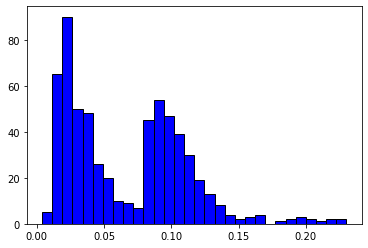

In [ ]:
plt.hist(dist_rotated, color = 'blue', edgecolor = 'black',
         bins = int(150/5))


In [ ]:
c = 0
dist_noises1 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for var in range(5,10,1):
        image2 = random_noise(img_array,mode = 'gaussian',var=var/100)
        images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises1.append(hamming_dist(hash1,attacked_hash))
      



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 4.,  1.,  3.,  4.,  5.,  3.,  9.,  7.,  0., 18.,  8.,  5.,  6.,
         6.,  3.,  4.,  8.,  5., 14.,  5.,  5.,  1.,  2.,  5.,  0.,  1.,
         1.,  1.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,  1.]),
 array([0.1031746 , 0.11155203, 0.11992945, 0.12830688, 0.1366843 ,
        0.14506173, 0.15343915, 0.16181658, 0.170194  , 0.17857143,
        0.18694885, 0.19532628, 0.2037037 , 0.21208113, 0.22045855,
        0.22883598, 0.2372134 , 0.24559083, 0.25396825, 0.26234568,
        0.2707231 , 0.27910053, 0.28747795, 0.29585538, 0.3042328 ,
        0.31261023, 0.32098765, 0.32936508, 0.3377425 , 0.34611993,
        0.35449735, 0.36287478, 0.3712522 , 0.37962963, 0.38800705,
        0.39638448, 0.4047619 ]),
 <a list of 36 Patch objects>)

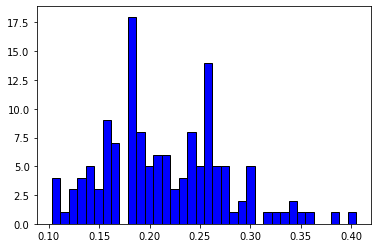

In [ ]:
plt.hist(dist_noises1, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [ ]:
c = 0
dist_noises4 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    image2 = random_noise(img_array,mode = 'poisson')
    images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises4.append(hamming_dist(hash1,attacked_hash))
      



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([1., 1., 0., 0., 0., 3., 0., 1., 1., 2., 0., 0., 3., 1., 2., 0., 3.,
        2., 1., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 1.]),
 array([0.01190476, 0.01554233, 0.01917989, 0.02281746, 0.02645503,
        0.03009259, 0.03373016, 0.03736772, 0.04100529, 0.04464286,
        0.04828042, 0.05191799, 0.05555556, 0.05919312, 0.06283069,
        0.06646825, 0.07010582, 0.07374339, 0.07738095, 0.08101852,
        0.08465608, 0.08829365, 0.09193122, 0.09556878, 0.09920635,
        0.10284392, 0.10648148, 0.11011905, 0.11375661, 0.11739418,
        0.12103175, 0.12466931, 0.12830688, 0.13194444, 0.13558201,
        0.13921958, 0.14285714]),
 <a list of 36 Patch objects>)

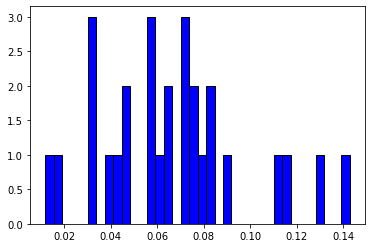

In [ ]:
plt.hist(dist_noises4, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [ ]:
c = 0
dist_noises2 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for amount in range(1,11,1):
        image2 = salt_pepper(image,amount/10)
        images.append(image2)

    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises2.append(hamming_dist(hash1,attacked_hash))

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 4.,  9., 11., 12.,  5.,  8., 10., 10.,  6.,  4., 13.,  7., 12.,
        18.,  7., 12., 23., 20., 16., 14., 17.,  6.,  7.,  3.,  3.,  5.,
         2.,  1.,  3.,  1.,  3.,  0.,  4.,  3.,  0.,  1.]),
 array([0.00396825, 0.01951058, 0.03505291, 0.05059524, 0.06613757,
        0.08167989, 0.09722222, 0.11276455, 0.12830688, 0.14384921,
        0.15939153, 0.17493386, 0.19047619, 0.20601852, 0.22156085,
        0.23710317, 0.2526455 , 0.26818783, 0.28373016, 0.29927249,
        0.31481481, 0.33035714, 0.34589947, 0.3614418 , 0.37698413,
        0.39252646, 0.40806878, 0.42361111, 0.43915344, 0.45469577,
        0.4702381 , 0.48578042, 0.50132275, 0.51686508, 0.53240741,
        0.54794974, 0.56349206]),
 <a list of 36 Patch objects>)

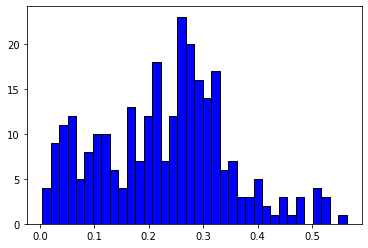

In [ ]:
plt.hist(dist_noises2, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [ ]:
c = 0
dist_noises3 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for crop in range(5,10,1):
        central_cropped_image = tf.image.central_crop(image,crop/10)
        with tf.Session() as sess:
            image2 = sess.run(central_cropped_image)
            images.append(image2)

    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises3.append(hamming_dist(hash1,attacked_hash))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 1.,  3.,  0.,  4.,  1.,  4.,  7.,  8.,  7.,  3.,  8.,  8., 11.,
         5.,  5.,  6.,  7.,  4.,  5.,  5.,  5.,  4.,  5.,  3.,  5.,  4.,
         0.,  2.,  4.,  0.,  1.,  1.,  0.,  2.,  1.,  1.]),
 array([0.05952381, 0.0741843 , 0.0888448 , 0.10350529, 0.11816578,
        0.13282628, 0.14748677, 0.16214727, 0.17680776, 0.19146825,
        0.20612875, 0.22078924, 0.23544974, 0.25011023, 0.26477072,
        0.27943122, 0.29409171, 0.3087522 , 0.3234127 , 0.33807319,
        0.35273369, 0.36739418, 0.38205467, 0.39671517, 0.41137566,
        0.42603616, 0.44069665, 0.45535714, 0.47001764, 0.48467813,
        0.49933862, 0.51399912, 0.52865961, 0.54332011, 0.5579806 ,
        0.57264109, 0.58730159]),
 <a list of 36 Patch objects>)

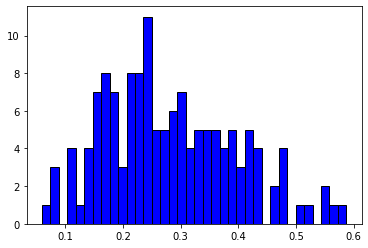

In [ ]:
plt.hist(dist_noises3, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for var in range(5,21,1):
        image2 = random_noise(img_array,mode = 'gaussian',var=var/100)
        images.append(image2)
    
    for amount in range(1,11,1):
        image2 = salt_pepper(image,amount/10)
        images.append(image2)
    
    for crop in range(3,10,1):
        central_cropped_image = tf.image.central_crop(image,crop/10)
        with tf.Session() as sess:
            image2 = sess.run(central_cropped_image)
            images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,512,512,new_cols)
        dist_noises.append(hamming_dist(hash1,attacked_hash))
        
      

In [ ]:
dist_noises

[0.09448818897637795,
 0.06299212598425197,
 0.047244094488188976,
 0.11023622047244094,
 0.07874015748031496,
 0.047244094488188976,
 0.07086614173228346,
 0.11023622047244094,
 0.13385826771653545,
 0.08661417322834646,
 0.08661417322834646,
 0.09448818897637795,
 0.12598425196850394,
 0.10236220472440945,
 0.10236220472440945,
 0.11811023622047244,
 0.07086614173228346,
 0.07086614173228346,
 0.09448818897637795,
 0.08661417322834646,
 0.14173228346456693,
 0.12598425196850394,
 0.11811023622047244,
 0.15748031496062992,
 0.15748031496062992,
 0.16535433070866143,
 0.3937007874015748,
 0.3464566929133858,
 0.3464566929133858,
 0.31496062992125984,
 0.2440944881889764,
 0.2047244094488189,
 0.14960629921259844,
 0.031496062992125984,
 0.031496062992125984,
 0.023622047244094488,
 0.03937007874015748,
 0.031496062992125984,
 0.03937007874015748,
 0.047244094488188976,
 0.03937007874015748,
 0.03937007874015748,
 0.03937007874015748,
 0.047244094488188976,
 0.047244094488188976,
 0.047

(array([ 1.,  0.,  1.,  0.,  0.,  2.,  2.,  4.,  3.,  3.,  4.,  3.,  8.,
        11.,  6., 13.,  3.,  9.,  8., 15., 14.,  7., 13., 16.,  6.,  9.,
         4.,  1.,  6.,  3.,  5.,  6.,  6.,  2.,  4.,  2.]),
 array([0.1468254 , 0.16027337, 0.17372134, 0.18716931, 0.20061728,
        0.21406526, 0.22751323, 0.2409612 , 0.25440917, 0.26785714,
        0.28130511, 0.29475309, 0.30820106, 0.32164903, 0.335097  ,
        0.34854497, 0.36199295, 0.37544092, 0.38888889, 0.40233686,
        0.41578483, 0.4292328 , 0.44268078, 0.45612875, 0.46957672,
        0.48302469, 0.49647266, 0.50992063, 0.52336861, 0.53681658,
        0.55026455, 0.56371252, 0.57716049, 0.59060847, 0.60405644,
        0.61750441, 0.63095238]),
 <a list of 36 Patch objects>)

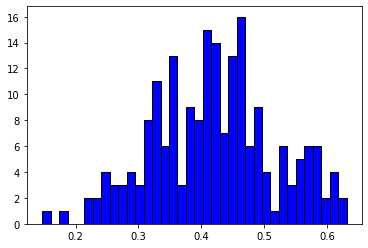

In [ ]:
plt.hist(dist_noises, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [ ]:
dist_diff = []
c = 0
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/'+file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    for files in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
        if(files==file):
            continue
        image1 = plt.imread(path + '/'+files)
        hash2 = image_to_hash(image1,256,256,new_cols)
        dist_diff.append(hamming_dist(hash1,hash2))
        ##print(hamming_dist(hash1,hash2))
        if(hamming_dist(hash1,hash2)==0.0):
           print(file)
           print(files)
           print('\n')

1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: ignored

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/ALL DB2"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB2"):
    image = plt.imread(path + '/'+file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,512,512,new_cols)
    for files in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB2"):
        if(files==file):
            continue
        image1 = plt.imread(path + '/'+files)
        hash2 = image_to_hash(image1,512,512,new_cols)
        dist_diff.append(hamming_dist(hash1,hash2))
        ##print(hamming_dist(hash1,hash2))

2
(63, 3228)
63
(63, 3228)
63


NameError: ignored

In [ ]:
dist_diff

[0.5119047619047619,
 0.44841269841269843,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.5595238095238095,
 0.47619047619047616,
 0.47619047619047616,
 0.5714285714285714,
 0.35714285714285715,
 0.47619047619047616,
 0.5555555555555556,
 0.47619047619047616,
 0.5357142857142857,
 0.5634920634920635,
 0.47619047619047616,
 0.36507936507936506,
 0.47619047619047616,
 0.30158730158730157,
 0.3888888888888889,
 0.47619047619047616,
 0.46825396825396826,
 0.5119047619047619,
 0.48412698412698413,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5515873015873016,
 0.5,
 0.5515873015873016,
 0.5515873015873016,
 0.3134920634920635,
 0.5436507936507936,
 0.5515873015873016,
 0.4087301587301587,
 0.5515873015873016,
 0.5476190476190477,
 0.45634920634920634,
 0.551

(array([ 4.,  2.,  6.,  5.,  5.,  7., 13., 17.,  6., 14., 13., 16., 13.,
        15., 19., 19., 16., 19., 14., 16., 11.,  5., 10.,  8.,  3.,  3.,
         2.,  0.,  3.,  3.]),
 array([0.15873016, 0.17420635, 0.18968254, 0.20515873, 0.22063492,
        0.23611111, 0.2515873 , 0.26706349, 0.28253968, 0.29801587,
        0.31349206, 0.32896825, 0.34444444, 0.35992063, 0.37539683,
        0.39087302, 0.40634921, 0.4218254 , 0.43730159, 0.45277778,
        0.46825397, 0.48373016, 0.49920635, 0.51468254, 0.53015873,
        0.54563492, 0.56111111, 0.5765873 , 0.59206349, 0.60753968,
        0.62301587]),
 <a list of 30 Patch objects>)

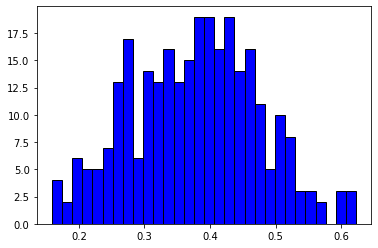

In [ ]:
plt.hist(dist_diff, color = 'blue', edgecolor = 'black',
         bins = int(150/5))
